In [1]:
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# 获取数据

1. 得到回归左边的Y

In [2]:
df_return_1qi=pd.read_csv('../RawData/1Qi_dianwei.csv', index_col=0).pct_change().dropna()

2. 得到无风险利率rf

In [3]:
rf=get_yield_curve(start_date='20180504',end_date='20180709',tenor=None)['0S']
series_rf=(rf+1)**(1/244)-1

3. 得到rm

In [4]:
'''
这里多出的步骤主要是为了将series转为dataframe
'''
rm = get_price_change_rate('000300.XSHG',start_date='20180504', end_date='20180709')           
df_return_rm=pd.DataFrame()
df_return_rm['000300.XSHG']=rm[:].values
df_return_rm.index=rm.index.values                                                         


4. 得到rb

In [5]:
rb=(df_return_rm['000300.XSHG']-series_rf).dropna()

5. 得到所有股票的市值和bp值

In [6]:
df_all_stocks_data = get_fundamentals(
    query(
        fundamentals.eod_derivative_indicator.pb_ratio,
        fundamentals.eod_derivative_indicator.market_cap)
    , '20171229', interval = '1d' ,report_quarter = False)
df_all_stocks_data = df_all_stocks_data.major_xs(df_all_stocks_data.major_axis[0])
df_all_stocks_data['bp_ratio'] = 1/df_all_stocks_data['pb_ratio']
del df_all_stocks_data['pb_ratio']
df_all_stocks_data = df_all_stocks_data.dropna(how = 'any')
df_return_all_stocks=get_price_change_rate(list(df_all_stocks_data.index),start_date='20180504', end_date='20180709')
'''
用了多余步骤去复制dataframe，可能是因为不知道可变对象的deepcopy复制,目的是为了删除df_all_stocks_data中没有return数据的股票
'''
columns=df_return_all_stocks.columns
index=df_return_all_stocks.index.tolist()
df_return_all_stocks_2=pd.DataFrame(df_return_all_stocks.values, columns=[columns],index=[index])
test=df_return_all_stocks_2.T.dropna(how='any').T
stock_need_drop = list(set(df_return_all_stocks_2.columns).difference(set(test.columns)))
df_all_stocks_data=df_all_stocks_data.T
for stocks in stock_need_drop:
    for stock in stocks:                                 #因为返回的是一个类似[('a',)]的结构
        del df_all_stocks_data[stock]

6. 得到S；B；L；M；H的股票分类    

# 处理数据

1. 计算SL;SM;SH;BL;BM;BH的股票组合和股票收益

In [7]:
df_all_stocks_data=df_all_stocks_data.T
df_all_stocks_data = df_all_stocks_data.sort_values('market_cap') #市值升序排布
S = df_all_stocks_data.index[:int(len(df_all_stocks_data.index)/2)]
B = df_all_stocks_data.index[int(len(df_all_stocks_data.index)/2):]
df_all_stocks_data = df_all_stocks_data.sort_values('bp_ratio') #净市率升序排列
L = df_all_stocks_data.index[:int(len(df_all_stocks_data.index)*0.3)]
M = df_all_stocks_data.index[int(len(df_all_stocks_data.index)*0.3):int(len(df_all_stocks_data.index)*0.7)]
H = df_all_stocks_data.index[int(len(df_all_stocks_data.index)*0.7):]
portfolio = {}
portfolio['SL'] = list(set(S).intersection(set(L)))
portfolio['SM'] = list(set(S).intersection(set(M)))
portfolio['SH'] = list(set(S).intersection(set(H)))
portfolio['BL'] = list(set(B).intersection(set(L)))
portfolio['BM'] = list(set(B).intersection(set(M)))
portfolio['BH'] = list(set(B).intersection(set(H)))

portfolio_return = {}
for por in portfolio:
    sector_return = 0
    for stock in portfolio[por]:
        sector_return += df_all_stocks_data['market_cap'][stock]*test[stock].values
    portfolio_return[por] = sector_return/np.sum(df_all_stocks_data['market_cap'][portfolio[por]])

2. 计算HML; BMS的因子

In [8]:
BMS = -(portfolio_return['SL']+portfolio_return['SM']+portfolio_return['SH'])/3+(portfolio_return['BL']+portfolio_return['BM']+portfolio_return['BH'])/3
HML = -(portfolio_return['SH']+portfolio_return['BH'])/2+(portfolio_return['SL']+portfolio_return['BL'])/2
BMS_cu=pd.Series(index=df_return_all_stocks.index)
HML_cu = BMS_cu.copy()

for i in range(len(BMS)):
    if i == 0:
        print("ok")
        BMS_cu[i] = 1+BMS[i]
        HML_cu[i] = 1+HML[i]
    else:
        BMS_cu[i] = BMS_cu[i-1]*(BMS[i]+1)
        HML_cu[i] = HML_cu[i-1]*(HML[i]+1)

ok


3. 绘制

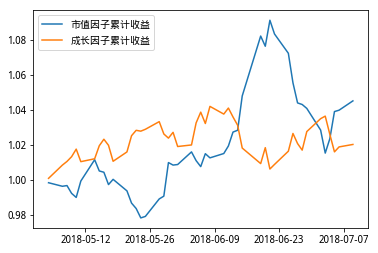

In [9]:
df2 = pd.DataFrame()
df2['BMS_cu'] = BMS_cu
df2['HML_cu'] = HML_cu
plt.plot(df2['BMS_cu'],label='市值因子累计收益')
plt.plot(df2['HML_cu'],label='成长因子累计收益')
plt.legend()

4. 回归

In [10]:
X = pd.DataFrame()
X['Rb'] = np.array(rb)
X['BMS'] = np.array(BMS)
X['HML'] = np.array(HML)

X = sm.add_constant(X)

Y = np.array(df_return_1qi)
est=sm.OLS(Y,X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     69.33
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           2.60e-16
Time:                        13:12:40   Log-Likelihood:                 151.10
No. Observations:                  46   AIC:                            -294.2
Df Residuals:                      42   BIC:                            -286.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.368      0.178      -0.001       0.005
Rb             1.5588      0.118     13.159      0.000       1.320       1.798
BMS            0.7386      0.192      3.840      0.000       0.350       1.127
HML            0.3002      0.287      1.046      0.302      -0.279       0.880
==============================================================================
Omnibus:                        5.388   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                4.303
Skew:                           0.556   Prob(JB):                        0.116
Kurtosis:                       4.005   Cond. No.                         228.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""